#  Supervised ML on Imbalanced Dataset
In this notebook, we train three classifiers on the imbalanced dataset by implementing cost sensitive method, undersampling, and SMOTE

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Dimensionality reduction
from sklearn.decomposition import PCA

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

# Pickle
import joblib

In [2]:
# Import custom class
%run -i '../src/helper/transfxn.py'
%run -i '../src/helper/ml.py'

# Load data

In [16]:
# Load cleaned data
df = pd.read_csv('../data/ml_data.csv')
df = df.sample(frac =1).reset_index(drop = True) # shuffle
print('Data size',df.shape) # data size
df.head()

Data size (3817613, 23)


,C_YEAR,C_MNTH,C_WDAY,C_HOUR,FATAL,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,2013,September,Thursday,15.0,0,3.0,Rear-end collision,At an intersection,"Overcast, cloudy but no precipitation",Wet,...,Light Duty Vehicle,2010.0,2.0,M,12.0,Second row,No Injury,Safety device used,Motor Vehicle Passenger,2100821
1,2003,May,Saturday,12.0,0,2.0,other,At an intersection,Clear and sunny,Normal,...,Light Duty Vehicle,1985.0,2.0,F,24.0,Front row,No Injury,Safety device used,Motor Vehicle Passenger,676809
2,2002,August,Wednesday,16.0,0,2.0,other,At an intersection,Clear and sunny,Normal,...,Light Duty Vehicle,1998.0,1.0,M,48.0,Driver,Injury,Safety device used,Motor Vehicle Driver,503523
3,2001,March,Monday,15.0,0,4.0,Rear-end collision,other,Clear and sunny,Normal,...,other,1999.0,1.0,M,34.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,323773
4,2006,September,Wednesday,15.0,0,3.0,Rear-end collision,At an intersection,Clear and sunny,Wet,...,Light Duty Vehicle,2004.0,1.0,F,23.0,Driver,Injury,Safety device used,Motor Vehicle Driver,1142023


## Class distribution

In [17]:
df.FATAL.value_counts()/len(df)*100

0    98.394049
1     1.605951
Name: FATAL, dtype: float64

## Develop model with reduced dataset
The dataset is very large to fit in a small laptop memory, training the entire dataset on a laptop will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into two subsets and train the model on the small subset

In [18]:
X1, X2, y1, y2 = train_test_split(df,df.FATAL, test_size = 0.003, random_state = 42, stratify = df.FATAL)

In [19]:
print('Large subset size:', X1.shape, y1.shape)
print('Small subset size:', X2.shape, y2.shape)

Large subset size: (3806160, 23) (3806160,)
Small subset size: (11453, 23) (11453,)


In [20]:
# Pickle the small subset
X2.to_pickle('../data/collision.pkl')

# Prepare the reduced dataset for machine learning

In [21]:
# Reload the small subset
df_small = pd.read_pickle('../data/collision.pkl')

In [22]:
# Feature matrix and class label
cols_to_drop = ['C_WDAY','P_ID', 'V_ID', 'FATAL']
X, y = df_small.drop(cols_to_drop, axis = 1), df_small['FATAL']

In [23]:
print('Data size:', X.shape, y.shape)

Data size: (11453, 19) (11453,)


## Create a Test Set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [25]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (9162, 19) (9162,)
Test set size: (2291, 19) (2291,)


In [26]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('--' * 15)
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    98.395547
1     1.604453
Name: FATAL, dtype: float64
------------------------------
Test set class distribution:
 0    98.384985
1     1.615015
Name: FATAL, dtype: float64


## Transformation pipeline

In [27]:
# Instantiate the class
transfxn = TransformationPipeline()

In [28]:
# Transform and scale data
X_train_scaled, X_test_scaled, feat_names = transfxn.preprocessing(X_train, X_test)

In [29]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (9162, 80)
Test set size after pre-processing: (2291, 80)


In [30]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation

In this section, we train three supervised ml models on the imbalanced dataset: 

1). Logistic Regression

2). Random Forest classifier

3). XGBoost classifier

The result shows that the overall accuracy of the model is not a good  performance measure on the imbalanced datasets, as it is bias towards the majority (negative) class. Therefore, we shall select and optimize the model with the best area under the receiver operating charateristics curve (AUROC) and the best precision-recall (AUPR) curve. 

In [31]:
# Instantiate the class
model = SupervisedModels()

## A-1. Logistic Regression

In [37]:
log_clf = LogisticRegression()   
model.model_selection_cv(log_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.990286 (0.002220)
AUROC: 0.876451
AUPRC: 0.541974
Predicted classes: [0 1]
Confusion matrix:
 [[9015    0]
 [  89   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9015
           1       1.00      0.39      0.57       147

    accuracy                           0.99      9162
   macro avg       1.00      0.70      0.78      9162
weighted avg       0.99      0.99      0.99      9162

---------------------------------------------------------------------------


## A-2. Random Forest Classifier

In [36]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model.model_selection_cv(rf_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.989849 (0.001448)
AUROC: 0.803557
AUPRC: 0.441330
Predicted classes: [0 1]
Confusion matrix:
 [[9015    0]
 [  93   54]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      9015
           1       1.00      0.37      0.54       147

    accuracy                           0.99      9162
   macro avg       0.99      0.68      0.77      9162
weighted avg       0.99      0.99      0.99      9162

---------------------------------------------------------------------------


## A-3. XGBoost

In [39]:
xgb_model = xgb.XGBClassifier(random_state = 42)
model.model_selection_cv(xgb_model, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.990177 (0.001792)
AUROC: 0.896006
AUPRC: 0.521249
Predicted classes: [0 1]
Confusion matrix:
 [[9014    1]
 [  89   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9015
           1       0.98      0.39      0.56       147

    accuracy                           0.99      9162
   macro avg       0.99      0.70      0.78      9162
weighted avg       0.99      0.99      0.99      9162

---------------------------------------------------------------------------


# B.  Hyperparameter Tuning and Cost Sensitive Method
 In this section, we shall optimize the **AUC** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [40]:
# Class ratio of the negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

61.326530612244895

## B-1. Logistic Regression

In [41]:
# Range of hyperparameters
param_grid = {'C': [2**(-5), 2**(-3), 2**(-1), 2**(0), 2**(1)], 
             'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]}
                             
# Grid search
gsearch_log = GridSearchCV(LogisticRegression(),param_grid, cv = 5,
                           scoring = 'roc_auc',verbose =1, n_jobs = -1)

# Fit the  training set
gsearch_log.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(gsearch_log.best_estimator_, '../data/log_clf.pkl')

# Print results
print('Grid search best AUC score:', gsearch_log.best_score_)
print('Grid search best parameters:', gsearch_log.best_params_)    

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   11.8s finished


Grid search best AUC score: 0.8788039091934898
Grid search best parameters: {'C': 0.5, 'class_weight': {0: 1, 1: 2}}


## B-2. Random Forest

In [42]:
# Range of hyperparameters
params = {'n_estimators': [100, 300, 500, 1000, 15000],
        'max_features': [0.5, 1, 'sqrt', 'log2', None], 
        'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 2}, {0: 1, 1: class_ratio}]}

# Randomized search
rf_clf = RandomForestClassifier(random_state = 42)           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 5, n_jobs = -1, 
                                random_state = 42, verbose = 1)  
# Fit the  training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../data/rf_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.3min finished


Randomized search best AUC score: 0.883403841617738
Randomized search best hyperparameters: {'n_estimators': 15000, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}


Text(0.5, 1.0, 'Top 20 Feature Importances')

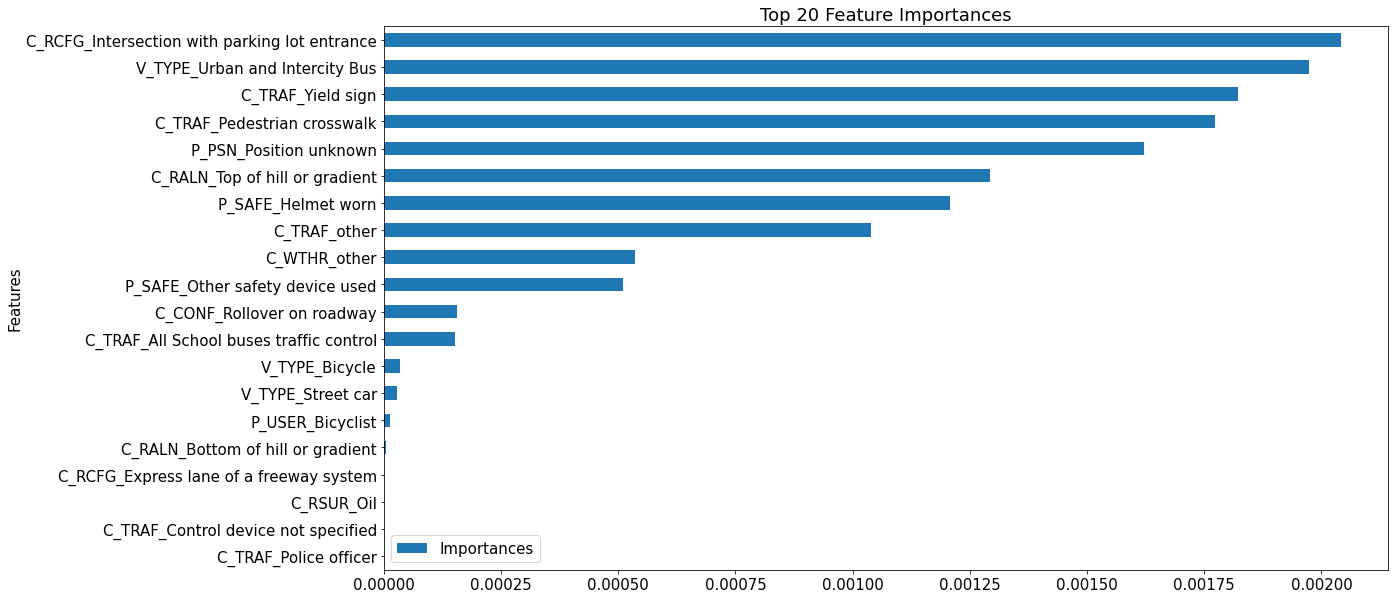

In [37]:
# Load trained model
rf_clf = joblib.load('../data/rf_clf.pkl')

# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names, 'Importances': rf_clf.feature_importances_})

# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.head(20).plot(kind='barh', figsize = (18,10))
plt.title('Top 20 Feature Importances')

## B-3. XGBoost

In [ ]:
# Range of hyperparameters
params = {'subsample':[i/10 for i in range(5,9)],'colsample_bytree': [i/10 for i in range(5,9)]}

# Randomized search
xgb_model = xgb.XGBClassifier(n_estimators = 2000, random_state = 42,
                              scale_pos_weight = class_ratio, learning_rate = 0.1, 
                              min_child_weight = 5, max_depth = 9)
rsearch_xgb = RandomizedSearchCV(estimator = xgb_model, param_distributions = params, 
                                  scoring = 'roc_auc', cv = 5, n_jobs = -1, 
                                  random_state = 42, verbose = 1)  
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../data/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

# C. Resampling Methods
In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## C-1. Under Sampling  combined with Random Forest Classifier
In undersampling, we reduce the majority class such that it matches the minority class

In [45]:
# Under sample the majority class
und = RandomUnderSampler(ratio = 'majority', random_state = 42)
X_train_scaled_und, y_train_und = und.fit_sample(X_train_scaled, y_train)

In [46]:
print('Undersampled training data size:', X_train_scaled_und.shape, y_train_und.shape)

Undersampled training data size: (294, 78) (294,)


In [47]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Imbalanced training set class distribution: [9015  147]
Undersampled training set class distribution: [147 147]


In [48]:
# Random Forest Classifier cross-validation on the undersampled dataset
rf_und = RandomForestClassifier(n_estimators = 1000,random_state = 42)
model.model_selection_cv(rf_und, X_train_scaled_und, y_train_und, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.792461 (0.052075)
AUROC: 0.867740
AUPRC: 0.894640
Predicted classes: [0 1]
Confusion matrix:
 [[126  21]
 [ 40 107]]
Classification report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       147
           1       0.84      0.73      0.78       147

    accuracy                           0.79       294
   macro avg       0.80      0.79      0.79       294
weighted avg       0.80      0.79      0.79       294

---------------------------------------------------------------------------


## C-2. SMOTE  combined with Random Forest Classifier
In Synthetic Minority Over Sampling Technique (SMOTE), we generate synthetic oberservations to match the minority clas.
SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

In [49]:
# Over sample the minority class
sm = SMOTE(ratio = 'minority', random_state = 42)
X_train_scaled_ovsm, y_train_ovsm = sm.fit_sample(X_train_scaled, y_train)

In [50]:
print('SMOTE training data size:', X_train_scaled_ovsm.shape, y_train_ovsm.shape)

SMOTE training data size: (18030, 78) (18030,)


In [51]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [9015  147]
SMOTE resampled training set class distribution: [9015 9015]


In [52]:
# Random Forest cross-validation on the SMOTE dataset
rf_ovsm = RandomForestClassifier(random_state = 42)
model.model_selection_cv(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.995286 (0.008738)
AUROC: 0.999686
AUPRC: 0.999715
Predicted classes: [0 1]
Confusion matrix:
 [[9009    6]
 [  79 8936]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      9015
           1       1.00      0.99      1.00      9015

    accuracy                           1.00     18030
   macro avg       1.00      1.00      1.00     18030
weighted avg       1.00      1.00      1.00     18030

---------------------------------------------------------------------------


## C-3. ROC and PR Curves on the Cross-Validation Training Set

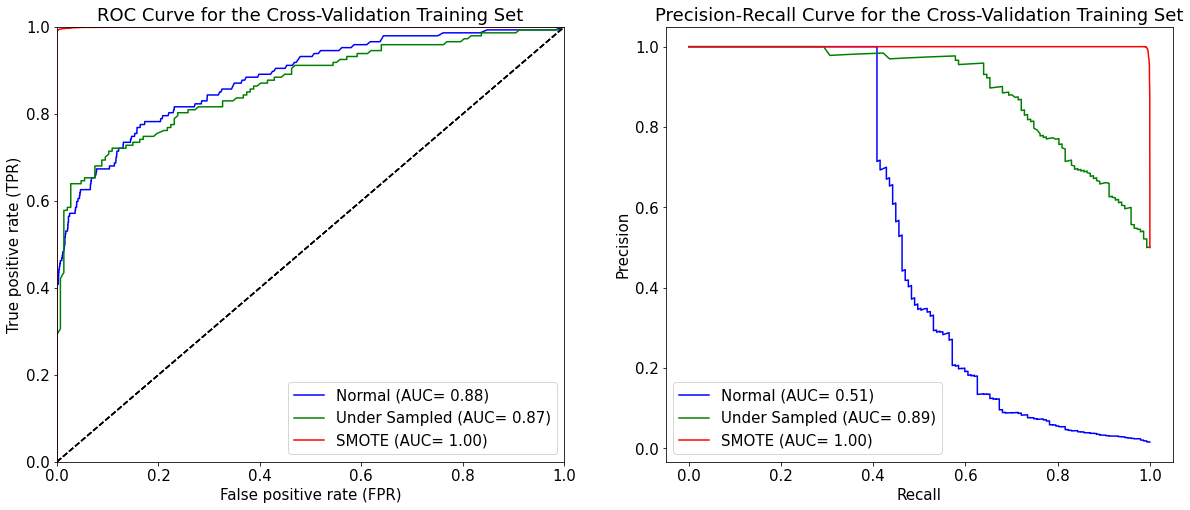

In [74]:
plt.figure(figsize = (20,8))

# Normal imbalanced distribution
rf_clf = joblib.load('../data/rf_clf.pkl') # Load trained model
model.plot_roc_prc_cv(rf_clf, X_train_scaled, y_train,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Under Sampled distribution
model.plot_roc_prc_cv(rf_und, X_train_scaled_und, y_train_und,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')
                     
# SMOTE distribution
model.plot_roc_prc_cv(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)') 

# D. Prediction on the Imbalanced Test Set 
In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## D-1. Normal Imbalanced Dataset

In [54]:
rf_clf = joblib.load('../data/rf_clf.pkl') # Load trained model
model.test_prediction(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.992143
AUROC: 0.898295
AUPRC: 0.589394
Predicted classes: [0 1]
Confusion matrix:
 [[2254    0]
 [  18   19]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2254
           1       1.00      0.51      0.68        37

    accuracy                           0.99      2291
   macro avg       1.00      0.76      0.84      2291
weighted avg       0.99      0.99      0.99      2291

---------------------------------------------------------------------------


## D-2. Undersampled Dataset

In [55]:
model.test_prediction(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.862942
AUROC: 0.892587
AUPRC: 0.494695
Predicted classes: [0 1]
Confusion matrix:
 [[1950  304]
 [  10   27]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      2254
           1       0.08      0.73      0.15        37

    accuracy                           0.86      2291
   macro avg       0.54      0.80      0.54      2291
weighted avg       0.98      0.86      0.91      2291

---------------------------------------------------------------------------


## D-3. SMOTE Dataset

In [56]:
model.test_prediction(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.992143
AUROC: 0.875267
AUPRC: 0.591628
Predicted classes: [0 1]
Confusion matrix:
 [[2254    0]
 [  18   19]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2254
           1       1.00      0.51      0.68        37

    accuracy                           0.99      2291
   macro avg       1.00      0.76      0.84      2291
weighted avg       0.99      0.99      0.99      2291

---------------------------------------------------------------------------


## D-4. ROC and PR Curves on the Test Set
The AUPRC of the normal imbalanced dataset is slightly higher than undersampling and SMOTE.

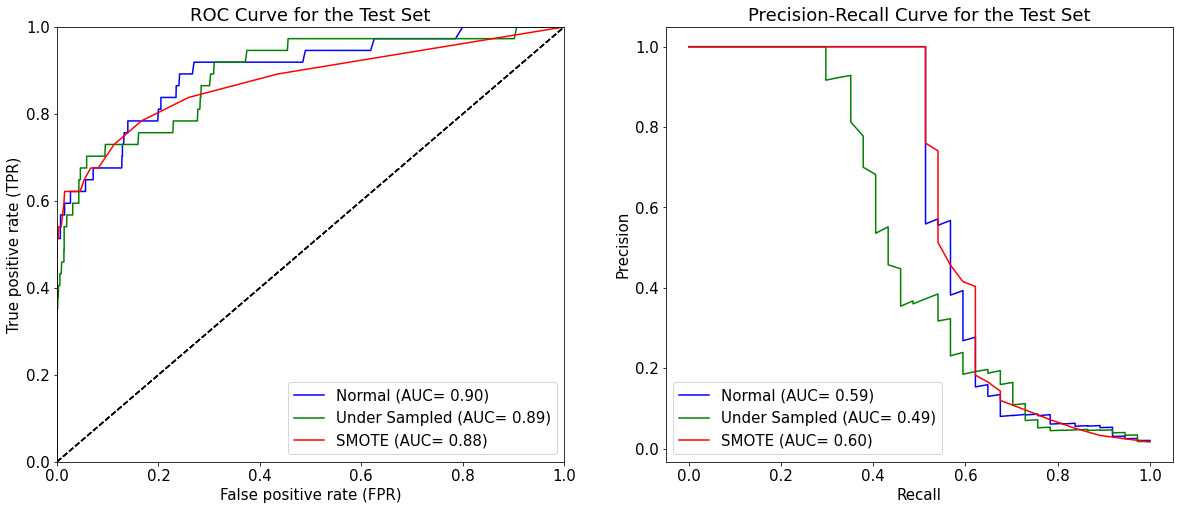

In [75]:
plt.figure(figsize = (20,8))

# Normal imbalanced distribution
rf_clf = joblib.load('../data/rf_clf.pkl') # Load trained model
model.plot_roc_prc(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Under Sampled distribution
model.plot_roc_prc(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')

# SMOTE distribution
model.plot_roc_prc(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)')